## Deep Image Prior
https://dmitryulyanov.github.io/deep_image_prior

Deep convolutional networks have become a popular tool for image generation and restoration. Generally, their excellent performance is imputed to their ability to learn realistic image priors from a large number of example images. In this paper, we show that, on the contrary, the structure of a generator network is sufficient to capture a great deal of low-level image statistics prior to any learning. In order to do so, we show that a randomly-initialized neural network can be used as a handcrafted prior with excellent results in standard inverse problems such as denoising, super-resolution, and inpainting. Furthermore, the same prior can be used to invert deep neural representations to diagnose them, and to restore images based on flash-no flash input pairs.

Apart from its diverse applications, our approach highlights the inductive bias captured by standard generator network architectures. It also bridges the gap between two very popular families of image restoration methods: learning-based methods using deep convolutional networks and learning-free methods based on handcrafted image priors such as self-similarity.

In [66]:
import os
import sys

# For one-level deep notebook
BASE_DIR = os.path.abspath("../")
if BASE_DIR not in sys.path:
    sys.path = [BASE_DIR] + sys.path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import (
    AveragePooling2D,
    Conv2D,
    Dense,
    Flatten,
    Input,
    Reshape,
    UpSampling2D,
)
from keras.models import Model, Sequential
from keras.optimizers import Adam
from skimage.exposure import rescale_intensity
from keras.utils import plot_model
from keras.backend import clear_session
import keras
from keras import layers

from utils.other import (
    make_noisy_images_gaussian,
    make_noisy_images_sp,
    make_noisy_images_speckle,
)

In [2]:
def normalize(image):
    return (image / 255 - 0.5) * 2


def to_image(normalized_image):
    return ((normalized_image / 2 + 0.5) * 255).astype(np.uint8)

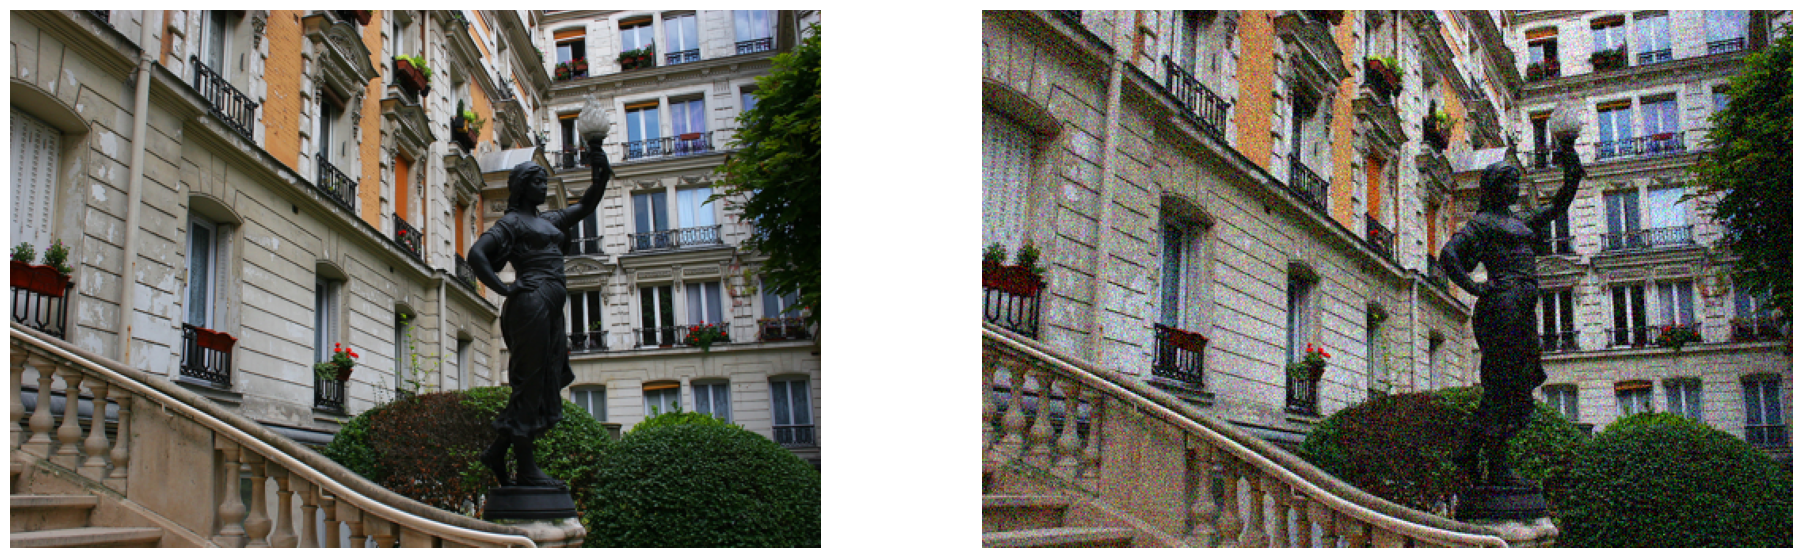

In [18]:
im = cv2.imread("../images/img_003_SRF_2_HR.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # BGR to RGB
im_noise = make_noisy_images_gaussian(im, 1)[0]

plt.figure(figsize=(23,23))
plt.subplot(121)
plt.axis("off")
plt.imshow(im)
plt.subplot(122)
plt.axis("off")
plt.imshow(im_noise)
plt.show()

In [70]:
encoder_input = keras.Input(shape=(340, 512, 3), name="img")
x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = layers.AveragePooling2D()(x)
x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
encoder_output = layers.Dense(128, activation="tanh")(x)
encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decorder_input = keras.Input(shape=(128,), name="encoded_img")
x = layers.Dense(192, activation="relu")(decorder_input)
x = layers.Reshape((12, 16, 1))(x)
x = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu")(x)
x = UpSampling2D()(x)
x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
x = UpSampling2D()(x)
x = Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
x = Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
x = UpSampling2D()(x)
x = Conv2D(filters=16, kernel_size=3, padding="same", activation="relu")(x)
x = Conv2D(filters=16, kernel_size=3, padding="same", activation="relu")(x)
x = UpSampling2D()(x)
x = Conv2D(filters=8, kernel_size=3, padding="same", activation="relu")(x)
decoder_output = Conv2D(filters=3, kernel_size=3, padding="same", activation="tanh")(x)
decoder = keras.Model(decorder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(340, 512, 3), name="img")
endcoded_img = encoder(autoencoder_input)
decoded_img = decoder(endcoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 340, 512, 3)]     0         
                                                                 
 conv2d_38 (Conv2D)          (None, 340, 512, 32)      896       
                                                                 
 conv2d_39 (Conv2D)          (None, 340, 512, 32)      9248      
                                                                 
 average_pooling2d_8 (Averag  (None, 170, 256, 32)     0         
 ePooling2D)                                                     
                                                                 
 conv2d_40 (Conv2D)          (None, 170, 256, 64)      18496     
                                                                 
 conv2d_41 (Conv2D)          (None, 170, 256, 64)      36928     
                                                           

In [64]:
clear_session()
def deep_image_prior_model():
    encoding_size = (340, 512, 3)

    encoder = Sequential(
        [
            Conv2D(
                filters=32,
                kernel_size=3,
                padding="same",
                input_shape=encoding_size,
                activation="relu",
                name="encoder_conv_1",
            ),
            Conv2D(
                filters=32,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="encoder_conv_2",
            ),
            AveragePooling2D(),
            Conv2D(
                filters=64,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="encoder_conv_3",
            ),
            Conv2D(
                filters=64,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="encoder_conv_4",
            ),
            AveragePooling2D(),
            Conv2D(
                filters=128,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="encoder_conv_5",
            ),
            Conv2D(
                filters=128,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="encoder_conv_6",
            ),
            Flatten(),
            Dense(units=128, activation="tanh"),
        ]
    )

    decoder = Sequential(
        [
            Dense(units=192, input_shape=encoding_size, activation="relu"),
            Reshape(target_shape=(8, 8, 3)),
            Conv2D(
                filters=128,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="decoder_conv_1",
            ),
            Conv2D(
                filters=128,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="decoder_conv_2",
            ),
            UpSampling2D(),
            Conv2D(
                filters=64,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="decoder_conv_3",
            ),
            Conv2D(
                filters=64,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="decoder_conv_4",
            ),
            UpSampling2D(),
            Conv2D(
                filters=32,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="decoder_conv_5",
            ),
            Conv2D(
                filters=32,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="decoder_conv_6",
            ),
            UpSampling2D(),
            Conv2D(
                filters=16,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="decoder_conv_7",
            ),
            Conv2D(
                filters=16,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="decoder_conv_8",
            ),
            UpSampling2D(),
            Conv2D(
                filters=8,
                kernel_size=3,
                padding="same",
                activation="relu",
                name="decoder_conv_9",
            ),
            Conv2D(
                filters=3,
                kernel_size=3,
                padding="same",
                activation="tanh",
                name="decoder_conv_10",
            ),
        ]
    )

    autoencoder = Sequential(
        [
            encoder,
            decoder,
        ]
    )

    autoencoder.compile(loss="mse", optimizer=Adam(learning_rate=0.0001))
    return autoencoder


model = deep_image_prior_model()
model.summary()

ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [340, 512, 192], output_shape = [8, 8, 3]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 340, 512, 192), dtype=float32)

In [62]:
x = (
    np.random.random(size=((1,) + im.shape)) * 2 - 1
)  # random noise in the range -1 to 1. This is similar to the range of tanh activation function used in the model.
y = rescale_intensity(im_noise[None, :], out_range=(-1, 1))
[x.shape, y.shape]

[(1, 340, 512, 3), (1, 340, 512, 3)]

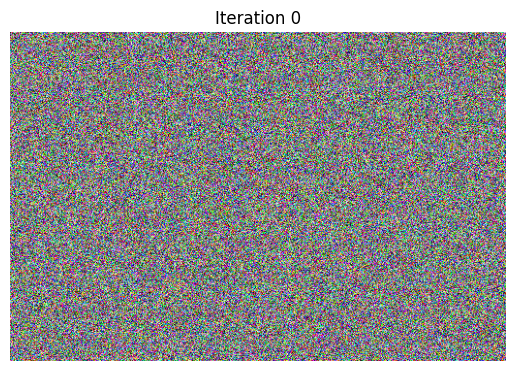

ValueError: in user code:

    File "/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/myn/LHL/Final project/.venv/lib/python3.10/site-packages/keras/losses.py", line 1500, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 128 and 340 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_2/sequential_1/decoder_conv_10/Tanh, IteratorGetNext:1)' with input shapes: [1,128,128,3], [1,340,512,3].


In [63]:
plt.axis("off")
plt.title("Iteration 0")
plt.imshow(rescale_intensity(x[0], out_range="uint8"))
plt.show()

iterations = 1  # in hundreds
results = np.empty(x.shape)

for i in range(iterations):
    model.fit(x, y, epochs=100, batch_size=1, verbose=0)
    output = model.predict(x)
    results = np.append(results, output, axis=0)
    plt.axis("off")
    plt.title("Iteration " + str((i + 1) * 100))
    plt.imshow(rescale_intensity(x[0], out_range="uint8"))
    plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(151)
plt.axis("off")
plt.title("Ground Truth")
plt.imshow(im)
plt.subplot(152)
plt.axis("off")
plt.title("Noisy Image")
plt.imshow(im_noise)
# i=10; plt.subplot(153); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
# i=16; plt.subplot(154); plt.axis('off'); plt.title('Rectified (Iteration ' + str((i+1)*100) + ')'); plt.imshow(to_image(results[i]))
i = 30
plt.subplot(153)
plt.axis("off")
plt.title("Rectified (Iteration " + str((i + 1) * 100) + ")")
plt.imshow(to_image(results[i]))
plt.show()